In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset

#### Read dataset

In [2]:
EVdata = pd.read_csv("stationAggDaytoDay2011_2020May12.csv", header = 0, index_col = 0)

In [3]:
EVdata.set_index('StartDate', inplace=True)

In [4]:
testData= EVdata.loc[EVdata["Station Name"] == "HAMILTON 1", ["Energy (kWh)"]]

In [5]:
testData = testData.rename(columns = {"Energy (kWh)": "target"})

In [6]:
testData["item_id"] = "HAMILTON 1"

In [7]:
testData.head()

,target,item_id
StartDate,,
2011-07-29,6.249457,HAMILTON 1
2011-07-30,28.978653,HAMILTON 1
2011-07-31,37.209163,HAMILTON 1
2011-08-01,5.041244,HAMILTON 1
2011-08-02,4.197217,HAMILTON 1


In [10]:
from gluonts.dataset.pandas import PandasDataset

In [8]:


ds = PandasDataset.from_long_dataframe(testData, target="target", item_id="item_id", freq = "D")

#### Handle missing data

In [11]:
max_end = max(testData.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in testData.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1D")
    print("new_index: ", new_index)
    print("gdf: ", gdf)
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    print("dfs_dict[item_id]: ", dfs_dict[item_id])
    dfs_dict[item_id][np.isnan(dfs_dict[item_id])] = 0
print(dfs_dict)

ds = PandasDataset(dfs_dict, target="target")


new_index:  DatetimeIndex(['2011-07-29', '2011-07-30', '2011-07-31', '2011-08-01',
               '2011-08-02', '2011-08-03', '2011-08-04', '2011-08-05',
               '2011-08-06', '2011-08-07',
               ...
               '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28',
               '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01',
               '2020-11-02', '2020-11-03'],
              dtype='datetime64[ns]', length=3386, freq='D')
gdf:                 target     item_id
StartDate                        
2011-07-29   6.249457  HAMILTON 1
2011-07-30  28.978653  HAMILTON 1
2011-07-31  37.209163  HAMILTON 1
2011-08-01   5.041244  HAMILTON 1
2011-08-02   4.197217  HAMILTON 1
...               ...         ...
2020-10-29  11.838000  HAMILTON 1
2020-10-30  25.440000  HAMILTON 1
2020-10-31  15.122000  HAMILTON 1
2020-11-01  44.383000  HAMILTON 1
2020-11-03   6.545000  HAMILTON 1

[3208 rows x 2 columns]
dfs_dict[item_id]:              target
2011-07-29     NaN
2011-0

In [65]:
next(iter(ds))

{'start': Period('2011-07-29', 'D'),
 'target': array([ 6.249457, 28.978653, 37.209163, ..., 44.383   ,  0.      ,
         6.545   ]),
 'item_id': 'HAMILTON 1'}

#### Use train and test split

In [11]:
prediction_length = 500
freq = "1D"
start = pd.Period('2011-07-29', freq = freq)

In [12]:
next(iter(ds))

{'start': Period('2011-07-29', 'D'),
 'target': array([ 6.249457, 28.978653, 37.209163, ..., 44.383   ,  0.      ,
         6.545   ]),
 'item_id': 'HAMILTON 1'}

In [13]:
custom_dataset = next(iter(ds))["target"]

In [14]:
custom_dataset.shape

(3386,)

In [15]:
custom_dataset = custom_dataset.reshape(1, len(custom_dataset))

In [16]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)

# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

#### Visualize the dataset

In [17]:
entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series

2011-07-29     6.249457
2011-07-30    28.978653
2011-07-31    37.209164
2011-08-01     5.041244
2011-08-02     4.197217
                ...    
2019-06-18    40.965000
2019-06-19    42.328999
2019-06-20    24.684000
2019-06-21    19.295000
2019-06-22    16.339001
Freq: D, Length: 2886, dtype: float32

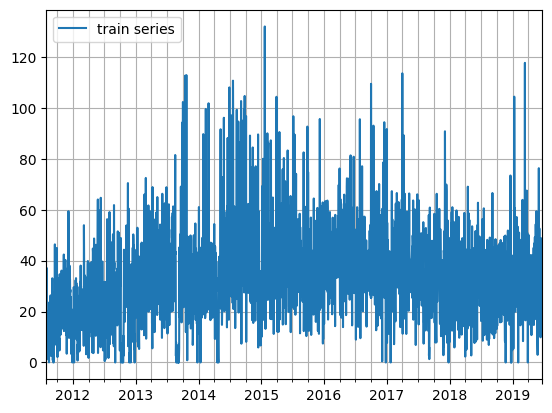

In [18]:
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

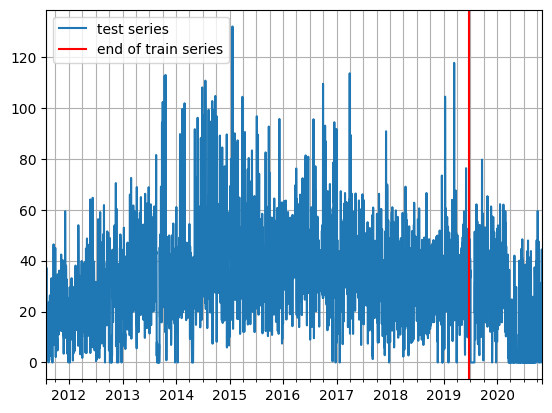

In [19]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [20]:
print(
    f"Length of forecasting window in test dataset: {prediction_length}"
)
print(f"Recommended prediction horizon: {prediction_length}")
print(f"Frequency of the time series: {freq}")

Length of forecasting window in test dataset: 500
Recommended prediction horizon: 500
Frequency of the time series: 1D


#### Train and prediction

##### Simple feed forward estimator

In [21]:
simple_feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[50], ## default: 50
    prediction_length=prediction_length,
    batch_normalization = False, ## default: false
    mean_scaling = True, ## default: true
    context_length=100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=10
    ),
)

##### MQCNN estimator

In [22]:
from gluonts.mx import MQCNNEstimator, Trainer

In [23]:
mqcnn_estimator = MQCNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=10
    ),
)

##### MQRNN estimator

In [24]:
from gluonts.mx import MQRNNEstimator, Trainer

In [25]:
mqrnn_estimator = MQRNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=10
    ),
)

##### DeepAR estimator

In [26]:
from gluonts.mx import DeepAREstimator, Trainer

In [27]:
deepAR_estimator = DeepAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepVAR estimator

In [28]:
from gluonts.mx import DeepVAREstimator, Trainer

In [29]:
deepVAR_estimator = DeepVAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    target_dim= 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### LSTNet

In [30]:
from gluonts.mx import LSTNetEstimator, Trainer

In [31]:
deepVAR_estimator = LSTNetEstimator(
    num_series = 1,
    prediction_length = prediction_length,
    ar_window = 10,
    channels = 1,
    context_length = 20,
    skip_size = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Temporal fusion transformer

In [32]:
from gluonts.mx import TemporalFusionTransformerEstimator, Trainer

In [33]:
tft_estimator = TemporalFusionTransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    hidden_dim = 10,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Transformer estimator

In [34]:
from gluonts.mx import TransformerEstimator, Trainer

In [35]:
transformer_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    context_length = 100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Deepfactor estimator

In [36]:
from gluonts.mx import DeepFactorEstimator, Trainer

In [37]:
deepFactor_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### GP estimator

In [38]:
from gluonts.mx import GaussianProcessEstimator, Trainer

In [39]:
gp_estimator = GaussianProcessEstimator(
    freq = freq,
    prediction_length = prediction_length,
    cardinality = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Naive predictor

In [40]:
from gluonts.ext.naive_2 import Naive2Predictor

In [41]:
naive_predictor = Naive2Predictor(
    prediction_length = prediction_length,
    season_length = 100
)

##### Train and predict

In [42]:
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator

def train_and_predict(train_dataset, test_dataset, estimator):
    predictor = estimator.train(train_dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset = test_dataset, predictor = predictor
    )
    
    return forecast_it, ts_it


In [43]:
## Available estmators: 
## transformer_estimator: transformer
## tft_estimator: temporal fusion transformer
## LSTNetEstimator: LSTnet
## DeepVAREstimator: DeepVAR
## DeepAREstimator: DeepAR
## simple_feed_forward_estimator: MLP
## deepFactor_estimator: deep factor
## gp_estimator: gaussian process
## mqcnn_estimator: MQ CNN
## rnn_estimator: RNN
estimator = simple_feed_forward_estimator

In [45]:
forecast_it, ts_it = train_and_predict(train_ds, test_ds, estimator)

100%|██████████| 10/10 [00:00<00:00, 32.05it/s, epoch=10/10, avg_epoch_loss=4.33]


##### Evaluation

In [46]:
forecast = list(forecast_it)
tss = list(ts_it)

In [47]:
forecast_entry = forecast[0]
ts_entry = tss[0]

In [48]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 500)
Start date of the forecast window: 2019-06-23
Frequency of the time series: <Day>


In [49]:
print(ts_entry)

                    0
2011-07-29   6.249457
2011-07-30  28.978653
2011-07-31  37.209164
2011-08-01   5.041244
2011-08-02   4.197217
...               ...
2020-10-30  25.440001
2020-10-31  15.122000
2020-11-01  44.382999
2020-11-02   0.000000
2020-11-03   6.545000

[3386 rows x 1 columns]


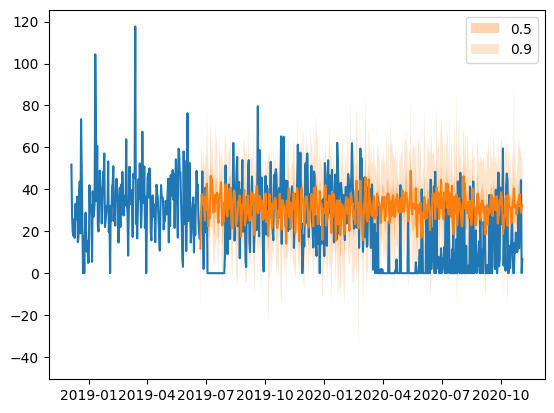

In [50]:
plt.plot(ts_entry[-700:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [51]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecast)

Running evaluation: 1it [00:00,  5.83it/s]


In [52]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 503.015,
    "abs_error": 9454.498046875,
    "abs_target_sum": 10153.2109375,
    "abs_target_mean": 20.306421875,
    "seasonal_error": 15.414398288561525,
    "MASE": 1.2267099720513706,
    "MAPE": 1.7611452241183658,
    "sMAPE": 0.9529680786132813,
    "MSIS": 7.757481792282074,
    "QuantileLoss[0.1]": 6195.056621655823,
    "Coverage[0.1]": 0.442,
    "QuantileLoss[0.5]": 9454.4974899292,
    "Coverage[0.5]": 0.654,
    "QuantileLoss[0.9]": 3431.1611953735346,
    "Coverage[0.9]": 0.914,
    "RMSE": 22.427995897984285,
    "NRMSE": 1.1044779841591015,
    "ND": 0.9311830617007705,
    "wQuantileLoss[0.1]": 0.6101573836878461,
    "wQuantileLoss[0.5]": 0.931183006846616,
    "wQuantileLoss[0.9]": 0.33793853161277676,
    "mean_absolute_QuantileLoss": 6360.238435652852,
    "mean_wQuantileLoss": 0.6264263073824129,
    "MAE_Coverage": 0.4140000000000001,
    "OWA": NaN
}


In [53]:
agg_metrics["MSE"]

503.015

In [54]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2019-06-23,503.015,9454.498047,10153.210938,20.306422,15.414398,1.22671,1.761145,0.952968,0.931183,7.757482,6195.056622,0.442,9454.49749,0.654,3431.161195,0.914


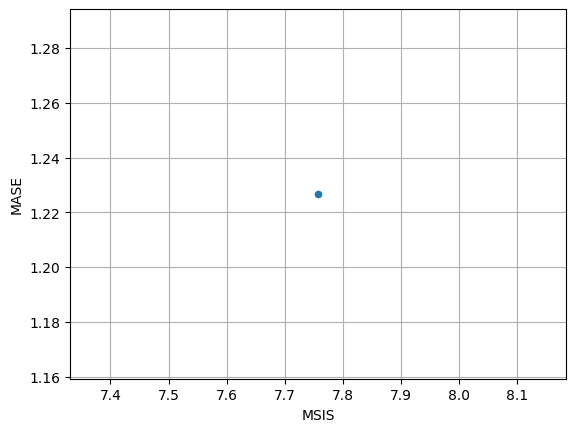

In [55]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()